<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Installation" data-toc-modified-id="Installation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Installation</a></span><ul class="toc-item"><li><span><a href="#Install-the-ode-module-from-scipy-1.0-beta" data-toc-modified-id="Install-the-ode-module-from-scipy-1.0-beta-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Install the ode module from scipy 1.0 beta</a></span></li><li><span><a href="#Install-contexttimer-and-joblib" data-toc-modified-id="Install-contexttimer-and-joblib-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Install contexttimer and joblib</a></span></li></ul></li><li><span><a href="#Van-der-Pol-oscillator" data-toc-modified-id="Van-der-Pol-oscillator-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Van der Pol oscillator</a></span><ul class="toc-item"><li><span><a href="#Use-functools.partial" data-toc-modified-id="Use-functools.partial-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Use <a href="https://docs.python.org/3/library/functools.html#functools.partial" target="_blank">functools.partial</a></a></span></li><li><span><a href="#Use-contexttimer" data-toc-modified-id="Use-contexttimer-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Use <a href="https://pypi.python.org/pypi/contexttimer/0.3.3" target="_blank">contexttimer</a></a></span></li></ul></li><li><span><a href="#Using-multiple-cores-with-joblib" data-toc-modified-id="Using-multiple-cores-with-joblib-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using multiple cores with joblib</a></span></li></ul></div>

# Installation


##  Install the ode module from scipy 1.0 beta

    git clone https://github.com/phaustin/eos_integrate.git
    cd eos_integrate
    pip install .
    
    
## Install contexttimer and joblib

    pip install contexttimer
    conda install joblib
    

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from eos_integrate import solve_ivp, DenseOutput

# Van der Pol oscillator

The system for Van der Pol oscillator is given as:
$$
y_1' = y_2, \\
y_2' = \mu (1 - y_1^2) y_2 - y_1 \\
y_1(0) = 2, \quad y_2(0) = 0
$$
It becomes stiff for high values of $\mu$, meaning that regions of rapid transition are followed by regions where the solution varies slowly. Explicit methods either diverge or make prohibitevely many steps for stiff problems, thus implicit methods should be used. Our function `solve_ivp` implements a one-step fully implicit Runge-Kutta method of Radau II A family.

We want to solve this for a range of mu values

## Use [functools.partial](https://docs.python.org/3/library/functools.html#functools.partial)
to turn a derivs function with arguments (mu, t, y) into a function of (t,y)

In [2]:
import functools
import contexttimer
import time

def fun(mu, t, y):
    return [y[1], mu * (1 - y[0]**2) * y[1] - y[0]]
#
# create a new function specialize for mu=150
#
mu=150
derivs = functools.partial(fun,mu)           

## Use [contexttimer](https://pypi.python.org/pypi/contexttimer/0.3.3) 
to keep track of wall clock and execution time

In [3]:
tstart=0
tstop=50
y0init=2
y1init=0
with contexttimer.Timer(time.perf_counter) as wall:
    with contexttimer.Timer(time.process_time) as cpu:
        res = solve_ivp(derivs, [tstart,tstop], [y0init, y1init], method='RK45')
print((f'wall time is {wall.elapsed:5.2f} seconds '
        f'and cpu time is {cpu.elapsed:5.2f} seconds'))

wall time is  0.64 seconds and cpu time is  0.63 seconds


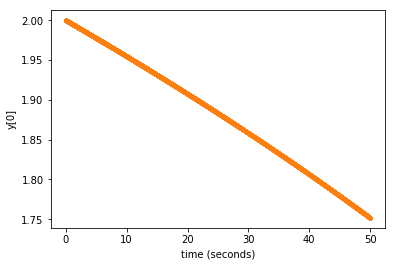

In [4]:
fig,ax=plt.subplots(1,1)
ax.plot(res.t, res.y[0])
ax.plot(res.t, res.y[0], '.');
ax.set(xlabel='time (seconds)',ylabel='y[0]');

# Using multiple cores with joblib

Suppose I want to solve the Van der Pol equation for many different mu values.
My macbook has two cores -- that should allow me to run multiple jobs more quickly.
The easiest way to do this kind of simple parallel processing in python is to use
the [joblib](https://pythonhosted.org/joblib/parallel.html#common-usage) module.

joblib requires that the jobs to be run be submitted as a list, with each job consisting of
three items:  

1) the function to be run
2) any required positional arguments to the function
3) any optional keyword arguments to the function

In [5]:
#
#  wrap the solver for joblib
#
#  keep the derivs function the same as above
#
def fun(mu, t, y):
    return [y[1], mu * (1 - y[0]**2) * y[1] - y[0]]
#
#  here is the "all in one" function that joblib needs to run to 
#  integrate the ode
#
def joblib_solver(fun,mu,tstart,tstop,y0init,y1init,method='RK45'):
    derivs = functools.partial(fun,mu) 
    res = solve_ivp(derivs, [tstart,tstop], [y0init, y1init], method=method)
    return res

In [14]:
#
# now create a list of 15 different jobs for joblib, 
# each with a different
# mu between 150 and 300 but with everything else the same
#
muvals=np.linspace(150,300,15)
joblist=[]
for mu in muvals:
    positional_args=[fun,mu,tstart,tstop,y0init,y1init]
    keyword_args={'method':'Radau'}
    joblist.append((joblib_solver,positional_args,keyword_args))

How long does it take to run 15 jobs on 1 core?  How about 2 cores?

Try changing 'RK45'  to 'Radau' in the cell above and see what the timing looks like

In [15]:
from joblib import Parallel
ncores=2
with contexttimer.Timer(time.perf_counter) as wall:
    with Parallel(n_jobs=ncores,backend='threading') as parallel:
        results=parallel(joblist)
print(f'wall time  with {ncores} cores is {wall.elapsed:5.2f} seconds')

wall time  with 2 cores is  0.20 seconds


Here is what the first result object looks like.

In [8]:
results[0]

  message: 'The solver successfully reached the interval end.'
     nfev: 43094
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([  0.00000000e+00,   4.99750125e-04,   2.35264801e-03, ...,
         4.99858013e+01,   4.99958455e+01,   5.00000000e+01])
 t_events: None
        y: array([[  2.00000000e+00,   1.99999977e+00,   1.99999599e+00, ...,
          1.75169452e+00,   1.75163782e+00,   1.75161438e+00],
       [  0.00000000e+00,  -8.95084185e-04,  -2.90211629e-03, ...,
         -5.63807005e-03,  -5.64069656e-03,  -5.64470704e-03]])

Plot all 15 results with a legend

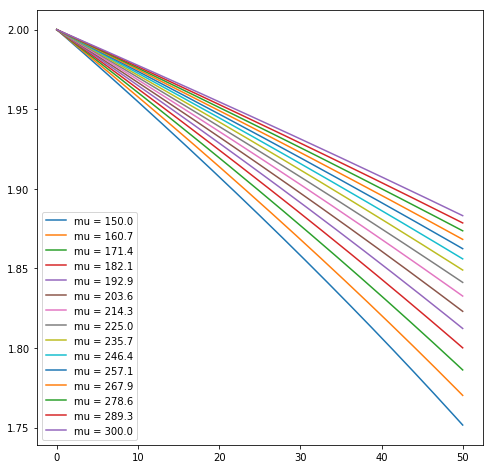

In [9]:
fig,ax=plt.subplots(1,1,figsize=[8,8])
for result,mu in zip(results,muvals):
    ax.plot(result.t,result.y[0],label=f'mu = {mu:5.1f}')
ax.legend();